<font color='black'><font size="4"> Notebook II: adding more features pour la prédiction scoring bancaire -- Le plan de ce notebook (Projet 7) est le suivant:</font></font>
<font color='black'><font size="3">
* Import les librairies
* Fonctions pour le reste des dataframes
* Important features avec lightgbm  
</font></font>  

## A) Import les libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pylab as pl

from joblib import dump, load 

import pickle
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import re

pl.rcParams.update({'font.size':14})


In [27]:
data_train = pd.read_csv('new_train.csv')
data_test = pd.read_csv('new_test.csv')

## B) Fonctions pour le reste des dataframes

<font color='darkblue'><font size="3">
Dans le précédent notebook jupyter nous avons appliqué une certaine procédure au dataframe afin de regrouper les informations des clients. Dans ce notebook, nous allons faire de même en utilisant des fonctions
</font></font>

In [31]:
## partie numérique

def app_numerique(data_train, data_test, data, name):
    
    groupby_data = data.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': name})
    data_train = data_train.merge(groupby_data, on = 'SK_ID_CURR', how = 'left')
    data_test = data_test.merge(groupby_data, on = 'SK_ID_CURR', how = 'left')

        # Group by the client id, calculate aggregation statistics
    previous = data.drop(columns = ['SK_ID_PREV']).groupby('SK_ID_CURR', as_index = False).agg([ 'mean', 'sum']).reset_index()
    previous.columns = ["_".join(x) for x in previous.columns.ravel()]

    previous.rename(columns={'SK_ID_CURR_':'SK_ID_CURR'},inplace= True)

    data_train = data_train.merge(previous, on = 'SK_ID_CURR', how = 'left')
    data_test = data_test.merge(previous, on = 'SK_ID_CURR', how = 'left')
    return data_train, data_test

## partie catégorie
def app_category(data_train, data_test, data):
    new_data = data.select_dtypes('object')
    new_data['SK_ID_CURR'] = data['SK_ID_CURR']
    new_dum = pd.get_dummies(new_data.set_index('SK_ID_CURR')).sum(level=0)
    
    data_train = data_train.merge(new_dum, on = 'SK_ID_CURR', how = 'left')
    data_test = data_test.merge(new_dum, on = 'SK_ID_CURR', how = 'left')
    data_train = data_train.fillna(0)
    data_test = data_test.fillna(0)
    return data_train, data_test

In [32]:
data_previous = pd.read_csv('previous_application.csv')

data_train, data_test = app_numerique(data_train, data_test, data_previous,'previous_loan')
data_train, data_test = app_category(data_train,data_test, data_previous)

<ipython-input-31-e9eb6c84aef6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SK_ID_CURR'] = data['SK_ID_CURR']


In [34]:
data_cash = pd.read_csv('POS_CASH_balance.csv')

data_train, data_test = app_numerique(data_train, data_test, data_cash,'cash_money')
data_train, data_test = app_category(data_train, data_test, data_cash)

<ipython-input-31-e9eb6c84aef6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SK_ID_CURR'] = data['SK_ID_CURR']


In [36]:
data_card = pd.read_csv('credit_card_balance.csv')

data_train, data_test = app_numerique(data_train, data_test, data_card,'credit_card')
data_train, data_test = app_category(data_train ,data_test, data_card)

<ipython-input-31-e9eb6c84aef6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SK_ID_CURR'] = data['SK_ID_CURR']


In [37]:
data_payments = pd.read_csv('installments_payments.csv')

In [38]:
data_train, data_test = app_numerique(data_train, data_test, data_payments,'payments')

In [39]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df.columns:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            # Convert objects to category
        elif (df[c].dtypes == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtypes == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtypes == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
    return df

In [40]:
data_train = convert_types(data_train)
data_test = convert_types(data_test)

In [42]:
data = data_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data_2 = data_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## C) Important features avec lightgbm

<font color='darkblue'><font size="3">
Avec l'ajout de toutes ces features, il est préférable de vérifier l'importance de celles-ci et de supprimer celles qui ne le sont pas.
</font></font>

In [63]:
#pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [43]:
feature_importances = np.zeros(data_train.shape[1])

# LGBM modele avec plusieurs hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [44]:
for i in range(2):
    
    train_features, valid_features, train_y, valid_y = train_test_split(data.drop(columns=['TARGET']), data['TARGET'], test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # sauvegarder les feature_importances
    feature_importances = pd.DataFrame({'importance':model.feature_importances_}) 
    feature_importances['feature'] = train_features.columns
    
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

C:\Users\Rouba\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Rouba\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.777753	valid_0's binary_logloss: 0.518374
[200]	valid_0's auc: 0.779281	valid_0's binary_logloss: 0.517592


In [45]:
feature_importances

,importance,feature
32,137,EXT_SOURCE_2
31,127,EXT_SOURCE_1
33,122,EXT_SOURCE_3
12,122,DAYS_BIRTH
5,106,AMT_GOODS_PRICE
...,...,...
295,0,NAME_SELLER_INDUSTRY_Tourism
294,0,NAME_SELLER_INDUSTRY_MLMpartners
293,0,NAME_SELLER_INDUSTRY_Jewelry
202,0,NAME_CASH_LOAN_PURPOSE_Journey


In [46]:
# Trouver les caractéristiques d'importance 0
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 124 features with 0.0 importance


,importance,feature
295,0,NAME_SELLER_INDUSTRY_Tourism
294,0,NAME_SELLER_INDUSTRY_MLMpartners
293,0,NAME_SELLER_INDUSTRY_Jewelry
202,0,NAME_CASH_LOAN_PURPOSE_Journey
200,0,NAME_CASH_LOAN_PURPOSE_Gasificationwatersupply


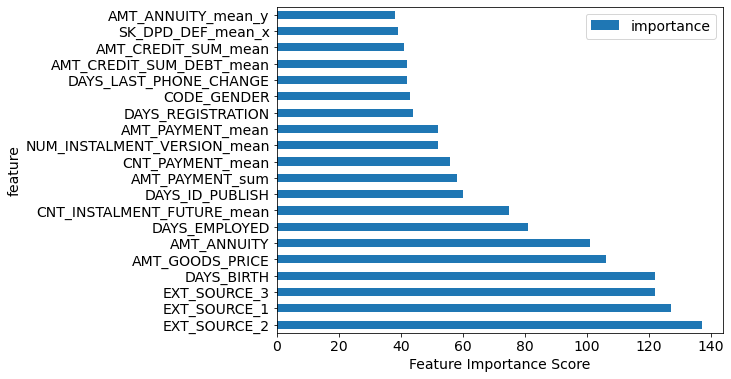

In [47]:
feature_importances.head(20).plot.barh(x='feature',y='importance', figsize=(8,6))

pl.xlabel('Feature Importance Score')
pl.show()

In [48]:
list_10 = feature_importances[feature_importances['importance']==0.0].feature

In [49]:
data_train = data.drop(columns=list_10)
data_test = data_2.drop(columns=list_10)

data = data_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data_2 = data_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

<font color='darkblue'><font size="3">
Nous pouvons réexécuter le modèle pour voir s'il identifie d'autres caractéristiques d'importance nulle.
</font></font>

In [50]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(data.drop(columns=['TARGET']), data['TARGET'], test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances = pd.DataFrame({'importance':model.feature_importances_}) 
    feature_importances['feature'] = train_features.columns
    
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

C:\Users\Rouba\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Rouba\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.777149	valid_0's binary_logloss: 0.518494
[200]	valid_0's auc: 0.780537	valid_0's binary_logloss: 0.517382


In [51]:
feature_importances.head()

,importance,feature
26,205,EXT_SOURCE_2
12,178,DAYS_BIRTH
25,169,EXT_SOURCE_1
27,164,EXT_SOURCE_3
5,147,AMT_GOODS_PRICE


In [52]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 8 features with 0.0 importance


,importance,feature
140,0,NAME_CASH_LOAN_PURPOSE_Other
71,0,CREDIT_CURRENCY_currency2
172,0,NAME_GOODS_CATEGORY_Jewelry
110,0,RATE_INTEREST_PRIVILEGED_sum
108,0,RATE_INTEREST_PRIMARY_sum


In [54]:
pickle.dump( data_train, open( "data_train_final.p", "wb" ) )
pickle.dump( data_test, open( "data_test_final.p", "wb" ) )

<font color='darkblue'><font size="3">
Le notebook jupyter suivant est P7_amelioration_score_ML.ipynb
</font></font>